# Storage + wind dispatch (self-contained)
This notebook loads input_data.csv, explores prices and wind scenarios, and solves the battery dispatch using the classical LP/MILP described in the summary (no netting between wind and the battery).

- Wind revenue is additive and independent of battery decisions under the stated rules; the battery problem reduces to price arbitrage.
- We solve two variants: (i) classical arbitrage with an equivalent-full-cycle (EFC) cap, and (ii) an optional "full-cycle-only" block search to forbid partial cycles.


In [1]:
print('hello world')

hello world


In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import pulp

%config InlineBackend.figure_format = 'retina'
sns.set_theme(style="whitegrid", context="talk")

# Load data (works whether run from repo root or test/)
data_path = Path('../data/input_data.csv')

df = pd.read_csv(data_path)
scenario_cols = [c for c in df.columns if c.startswith('scenario_')]

# Scenario aggregates
df['mean_wind'] = df[scenario_cols].mean(axis=1)
df['p10_wind'] = df[scenario_cols].quantile(0.10, axis=1)
df['p90_wind'] = df[scenario_cols].quantile(0.90, axis=1)


## Optimization model (Set-Point Tracking)

Let $t \in \{1,\dots,24\}$ index hours and $s \in \{1,\dots,13\}$ index equiprobable wind scenarios with probability $\pi_s = 1/13$. Prices $p_t$ are deterministic; wind energy in each scenario is $w_{t,s}$.

### Parameters
(from the statement)
- Battery energy capacity: $E^{\max} = 16$ MWh
- Charging power limit: $P^{\max}_{\mathrm{ch}} = 5$ MW (so $\le 5$ MWh per hour)
- Discharging power limit: $P^{\max}_{\mathrm{dis}} = 4$ MW (so $\le 4$ MWh per hour)
- Charging efficiency: $\eta_{\mathrm{ch}} = 0.8$
- Discharging efficiency: $\eta_{\mathrm{dis}} = 1.0$
- Initial and terminal SOC: $E_0 = 0$, $E_{24} = 0$
- Cycle budget (equivalent full cycles, EFC proxy): $\sum_{t=1}^{24} d_t \le N^{\mathrm{cyc}} E^{\max}$ with $N^{\mathrm{cyc}}
- Target battery charge/discharge rate (signal to track): $r_t^{sig} = Ap_t^{-\epsilon}$ MW (isoelastic economy model - $p_t$ is the price)

Optionally (if you want a soft preference for continuity):
- Switching/start penalty weight: $\lambda \ge 0$

### Decision variables (day-ahead, scenario-dependent)

Continuous variables:
- $c_{t,s} \ge 0$: charging energy bought from the grid (MWh) in hour $t$ for scenario $s$
- $d_{t,s} \ge 0$: discharging energy sold to the grid (MWh) in hour $t$ for scenario $s$
- $E_{t,s} \in [0, E^{\max}]$: state of charge at end of hour $t$ (MWh) for scenario $s$

Binary variables (3-state operation):
- $y^{\mathrm{ch}}_{t,s} \in \{0,1\}$: 1 if the battery is in charging mode at hour $t$ for scenario $s$
- $y^{\mathrm{dis}}_{t,s} \in \{0,1\}$: 1 if the battery is in discharging mode at hour $t$ for scenario $s$
- $y^{\mathrm{id}}_{t,s} \in \{0,1\}$: 1 if the battery is idle at hour $t$ for scenario $s$

Binary variables (to count contiguous blocks / starts): (not used for now)
- $u^{\mathrm{ch}}_{t,s} \in \{0,1\}$: 1 if a charging block starts at hour $t$
- $u^{\mathrm{dis}}_{t,s} \in \{0,1\}$: 1 if a discharging block starts at hour $t$

### Objective (expected revenue for each scenario)

$$\min \; \sum_{t=1}^{24} \bigl(\bigl(d_{t,s} - c_{t,s}\bigr)-r_t^{sig}\bigr)^2  + \lambda \sum_{t=1}^{24}\bigl(u^{\mathrm{ch}}_{t,s} + u^{\mathrm{dis}}_{t,s}\bigr)$$

The battery decision depends on the distance to the target net demand, which includes both the factor of the price varying and the requirement to provide a stable supply to the grid. It is penalized if you have large number of charge discharge starting blocks

### Constraints

**(1) SOC dynamics and bounds**

$$E_t = E_{t-1} + \eta_{\mathrm{ch}} c_{t,s} - \frac{1}{\eta_{\mathrm{dis}}} d_{t,s} \qquad \forall t=1,\dots,24$$

$$0 \le E_t \le E^{\max} \qquad \forall t=1,\dots,24$$

$$E_0 = 0,\qquad E_{24}=0$$

**(2) 3-state operation and power limits**

$$y^{\mathrm{ch}}_t + y^{\mathrm{dis}}_t + y^{\mathrm{id}}_t = 1 \qquad \forall t$$

$$0 \le c_t \le P^{\max}_{\mathrm{ch}}\, y^{\mathrm{ch}}_t \qquad \forall t$$

$$0 \le d_t \le P^{\max}_{\mathrm{dis}}\, y^{\mathrm{dis}}_t \qquad \forall t$$

**(3) "Continuous operation": no immediate charge$\leftrightarrow$discharge reversals**
(must pass through idle between opposite modes)

$$y^{\mathrm{ch}}_t + y^{\mathrm{dis}}_{t+1} \le 1 \qquad \forall t=1,\dots,23$$

$$y^{\mathrm{dis}}_t + y^{\mathrm{ch}}_{t+1} \le 1 \qquad \forall t=1,\dots,23$$

**(4) Count charging/discharging blocks (starts)**

$$u^{\mathrm{ch}}_1 \ge y^{\mathrm{ch}}_1,\qquad u^{\mathrm{dis}}_1 \ge y^{\mathrm{dis}}_1$$

$$u^{\mathrm{ch}}_t \ge y^{\mathrm{ch}}_t - y^{\mathrm{ch}}_{t-1} \qquad \forall t=2,\dots,24$$

$$u^{\mathrm{dis}}_t \ge y^{\mathrm{dis}}_t - y^{\mathrm{dis}}_{t-1} \qquad \forall t=2,\dots,24$$

**(5) Limit the number of charging/discharging blocks**
(to avoid frequent plugging/unplugging)

$$\sum_{t=1}^{24} u^{\mathrm{ch}}_t \le 2,\qquad \sum_{t=1}^{24} u^{\mathrm{dis}}_t \le 2$$

**(6) Cycle budget (EFC proxy)**

$$\sum_{t=1}^{24} d_t \le N^{\mathrm{cyc}} E^{\max} = 32$$


In [7]:
winds = np.array([[df[f"scenario_{s}"][t] for s in range(1,14)] for t in range(0,24)])
avg_total_wind = np.sum(np.mean(winds,axis=1))
price = np.array([df[f"price"][t] for t in range(0,24)])

# make total demand equal total average wind generation
ϵ = 0.25
A = avg_total_wind / np.sum(price**-ϵ) 
demand = A * price ** - ϵ

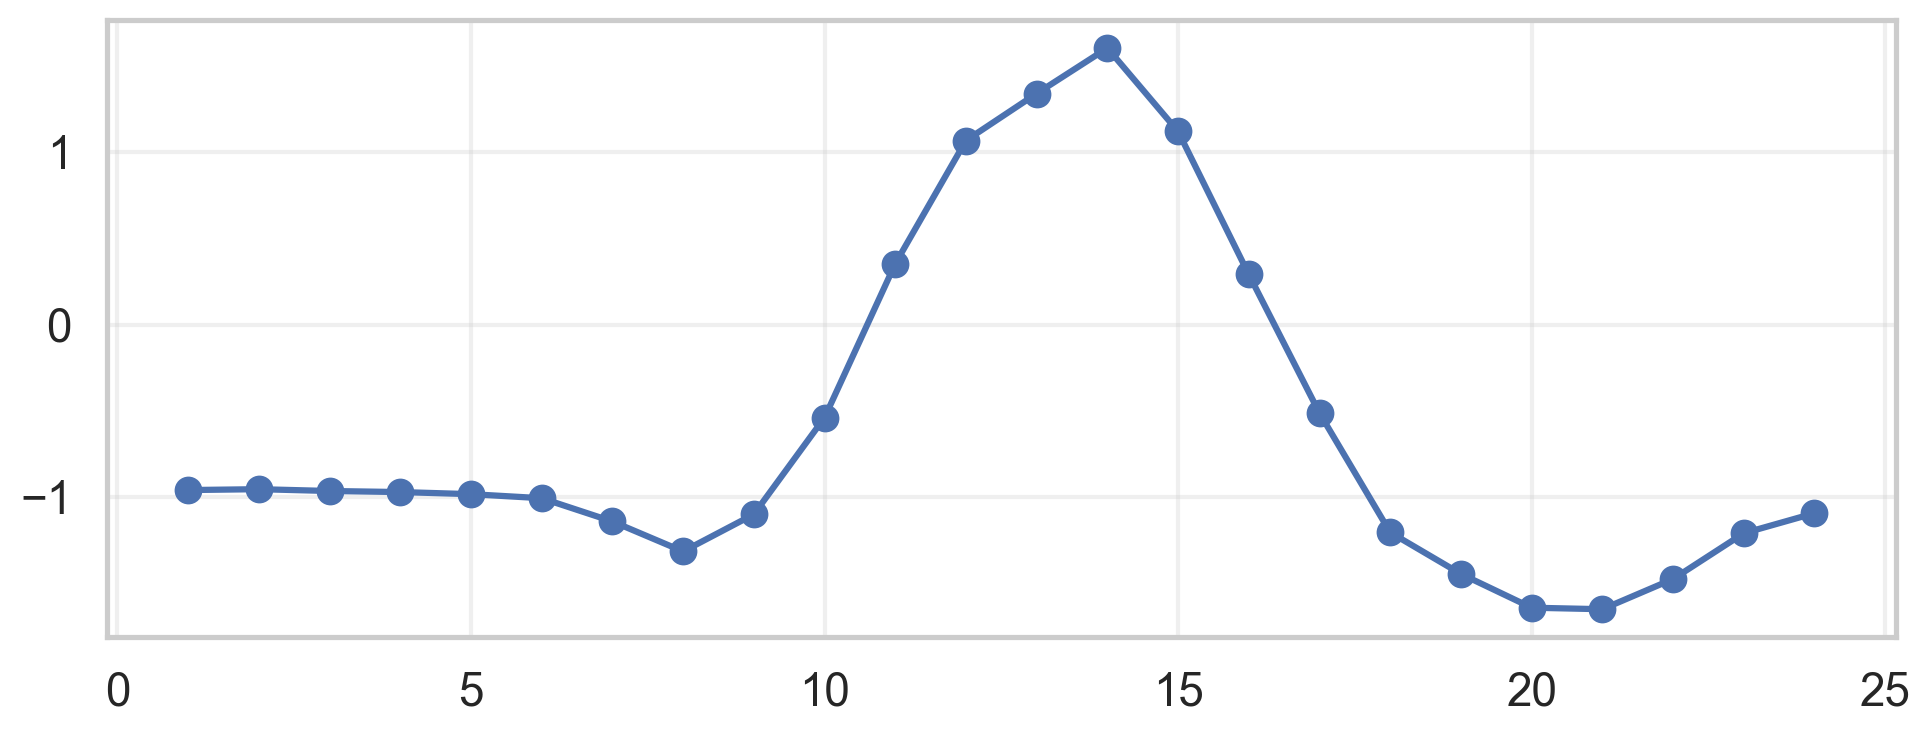

In [8]:
fig, ax = plt.subplots(figsize=(10,4))
# ax.plot(range(1,25),demand, marker='o')
# ax.plot(range(1,25),winds[:,0], marker='o')
hours = sorted(df["hour"].astype(int).tolist())
for s in range(0,1):
    target = dict(zip(hours, (demand - winds[:,s])/2))
    ax.plot(range(1,25), [target[t] for t in range(1,25)], marker='o')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [24]:
p_sig = {t: t**2 - t for t in hours}
target = dict(zip(hours, hours**2 - hours))
print(p_sig)
print(target)

{1: 0, 2: 2, 3: 6, 4: 12, 5: 20, 6: 30, 7: 42, 8: 56, 9: 72, 10: 90, 11: 110, 12: 132, 13: 156, 14: 182, 15: 210, 16: 240, 17: 272, 18: 306, 19: 342, 20: 380, 21: 420, 22: 462, 23: 506, 24: 552}
{1: 0, 2: 2, 3: 6, 4: 12, 5: 20, 6: 30, 7: 42, 8: 56, 9: 72, 10: 90, 11: 110, 12: 132, 13: 156, 14: 182, 15: 210, 16: 240, 17: 272, 18: 306, 19: 342, 20: 380, 21: 420, 22: 462, 23: 506, 24: 552}


In [29]:
scenario_cols = [c for c in df.columns if c.startswith("scenario_")]

# store output for each scenario
schedules = []
# Wind revenue statistics (independent of battery decisions under "no netting")
wind_rev_by_s = (df[scenario_cols].mul(df["price"], axis=0)).sum(axis=0)
wind_rev_exp = wind_rev_by_s.mean()
wind_rev_min = wind_rev_by_s.min()
wind_rev_max = wind_rev_by_s.max()

print(f"Expected wind revenue: EUR {wind_rev_exp:,.2f}")
print(f"Scenario range: EUR {wind_rev_min:,.2f} .. EUR {wind_rev_max:,.2f}")

# -----------------------
# Battery parameters
# -----------------------
Pch = 5.0
Pdis = 4.0
Emax = 16.0
eta_ch = 0.8
eta_dis = 1.0
max_cycles = 2  # EFC proxy: total discharge <= 2 * Emax

# Optional soft preference: penalize number of starts (set 0.0 to disable)
lambda_switch = 0.0

# Optional tightening: if you ever see dummy "mode=1 but power=0" artifacts, set eps > 0
eps = 0.0

hours = sorted(df["hour"].astype(int).tolist())
situations = np.arange(13) + 1
price = np.array([df[f"price"][t] for t in range(0,24)])
# -----------------------
# Model
# -----------------------
for s in range(0,13):
    wind_gen = winds[:,s]
    target = {t: float(demand[t - 1] - wind_gen[t - 1]) for t in hours}

    model = pulp.LpProblem("BatteryArbitrage_Continuous", pulp.LpMaximize)

    charge = pulp.LpVariable.dicts("charge", hours, lowBound=0)
    discharge = pulp.LpVariable.dicts("discharge", hours, lowBound=0)
    soc = pulp.LpVariable.dicts("soc", [0] + hours, lowBound=0, upBound=Emax)

    dev = pulp.LpVariable.dicts("dev", hours, lowBound=0)
    abs_dev = pulp.LpVariable.dicts("abs_dev", hours, lowBound=0)

    # 2-state mode binaries
    u_ch = pulp.LpVariable.dicts("u_ch", hours, cat="Binary")
    u_dis = pulp.LpVariable.dicts("u_dis", hours, cat="Binary")

    # Start (block) binaries
    start_ch = pulp.LpVariable.dicts("start_ch", hours, cat="Binary")
    start_dis = pulp.LpVariable.dicts("start_dis", hours, cat="Binary")

    # Initial SOC
    model += soc[0] == 0

    # Per-hour constraints
    for t in hours:
        # SOC recursion
        model += soc[t] == soc[t - 1] + eta_ch * charge[t] - (1.0 / eta_dis) * discharge[t]

        # Exactly one of: charge / discharge / idle
        model += u_ch[t] + u_dis[t] <= 1

        # Power limits
        model += charge[t] <= Pch * u_ch[t]
        model += discharge[t] <= Pdis * u_dis[t]

        # Optional tightening (usually keep eps = 0.0)
        # if eps > 0:
        #     model += charge[t] >= eps * u_ch[t]
        #     model += discharge[t] >= eps * u_dis[t]

        # deviation from the constant target at time t
        model += dev[t] == discharge[t] - charge[t] - target[t]
        model += abs_dev[t] >= dev[t]
        model += abs_dev[t] >= -dev[t]

    # End-of-day empty
    model += soc[hours[-1]] == 0

    # "Continuous operation": forbid immediate charge<->discharge reversals (must pass through idle)
    for t_prev, t in zip(hours[:-1], hours[1:]):
        model += u_ch[t_prev] + u_dis[t] <= 1
        model += u_dis[t_prev] + u_ch[t] <= 1

    # Start definition constraints (tight, so starts are counted correctly)
    t0 = hours[0]
    model += start_ch[t0] == u_ch[t0]
    model += start_dis[t0] == u_dis[t0]

    for t_prev, t in zip(hours[:-1], hours[1:]):
    # Charging starts at t iff u_ch[t]=1 and u_ch[t_prev]=0
        model += start_ch[t] >= u_ch[t] - u_ch[t_prev]
        model += start_ch[t] <= u_ch[t]
        model += start_ch[t] <= 1 - u_ch[t_prev]

    #  Discharging starts at t iff u_dis[t]=1 and u_dis[t_prev]=0
        model += start_dis[t] >= u_dis[t] - u_dis[t_prev]
        model += start_dis[t] <= u_dis[t]
        model += start_dis[t] <= 1 - u_dis[t_prev]

    # Limit number of blocks (at most 2 charging blocks and 2 discharging blocks)
    model += pulp.lpSum(start_ch[t] for t in hours) <= 2
    model += pulp.lpSum(start_dis[t] for t in hours) <= 2

    # Cycle proxy (EFC): total discharged energy <= 2 * Emax
    model += pulp.lpSum(discharge[t] for t in hours) <= max_cycles * Emax

    # Objective: minimize the track penalty, i.e. track the target rate
    start_penalty = lambda_switch * pulp.lpSum(start_ch[t] + start_dis[t] for t in hours)
    track_penalty = pulp.lpSum(abs_dev[t] for t in hours)
    
    model += - track_penalty
    # -----------------------
    # Solve
    # -----------------------
    model.solve(pulp.PULP_CBC_CMD(msg=0))

    status = pulp.LpStatus[model.status]
    battery_profit = np.array([discharge[t] - charge[t] for t in hours]) * price
    revenue = battery_profit + price * wind_gen
    
    battery_profit_tot = pulp.value(np.sum(battery_profit))
    revenue_tot = pulp.value(np.sum(revenue))

    print("Solver status:", status)
    print(f"Battery profit: EUR {battery_profit_tot:,.2f}")
    print(f"Total expected revenue (wind + battery): EUR {revenue_tot:,.2f}")

    # -----------------------
    # Schedule output (same style as yours)
    # -----------------------
    schedule = pd.DataFrame({
        "hour": hours,
        "charge_MWh": [charge[t].value() for t in hours],
        "discharge_MWh": [discharge[t].value() for t in hours],
        "soc_MWh": [soc[t].value() for t in hours],
        "mode_charge": [u_ch[t].value() for t in hours],
        "mode_discharge": [u_dis[t].value() for t in hours],
        "price": [price[t-1] for t in hours],
    })

    # Optional extra columns (useful for debugging continuity / blocks)
    schedule["start_charge_block"] = [start_ch[t].value() for t in hours]
    schedule["start_discharge_block"] = [start_dis[t].value() for t in hours]
    schedules.append(schedule)



Expected wind revenue: EUR 17,645.48
Scenario range: EUR 5,515.79 .. EUR 27,116.03
Solver status: Optimal
Battery profit: EUR -2,041.30
Total expected revenue (wind + battery): EUR 17,610.26
Solver status: Optimal
Battery profit: EUR -1,834.40
Total expected revenue (wind + battery): EUR 20,164.21
Solver status: Optimal
Battery profit: EUR -1,512.69
Total expected revenue (wind + battery): EUR 22,429.84
Solver status: Optimal
Battery profit: EUR 515.68
Total expected revenue (wind + battery): EUR 27,631.71
Solver status: Optimal
Battery profit: EUR -1,892.07
Total expected revenue (wind + battery): EUR 21,325.43
Solver status: Optimal
Battery profit: EUR -1,315.33
Total expected revenue (wind + battery): EUR 23,983.53
Solver status: Infeasible
Battery profit: EUR -1,965.94
Total expected revenue (wind + battery): EUR 16,177.31
Solver status: Infeasible
Battery profit: EUR -2,334.63
Total expected revenue (wind + battery): EUR 9,295.20
Solver status: Infeasible
Battery profit: EUR -409.

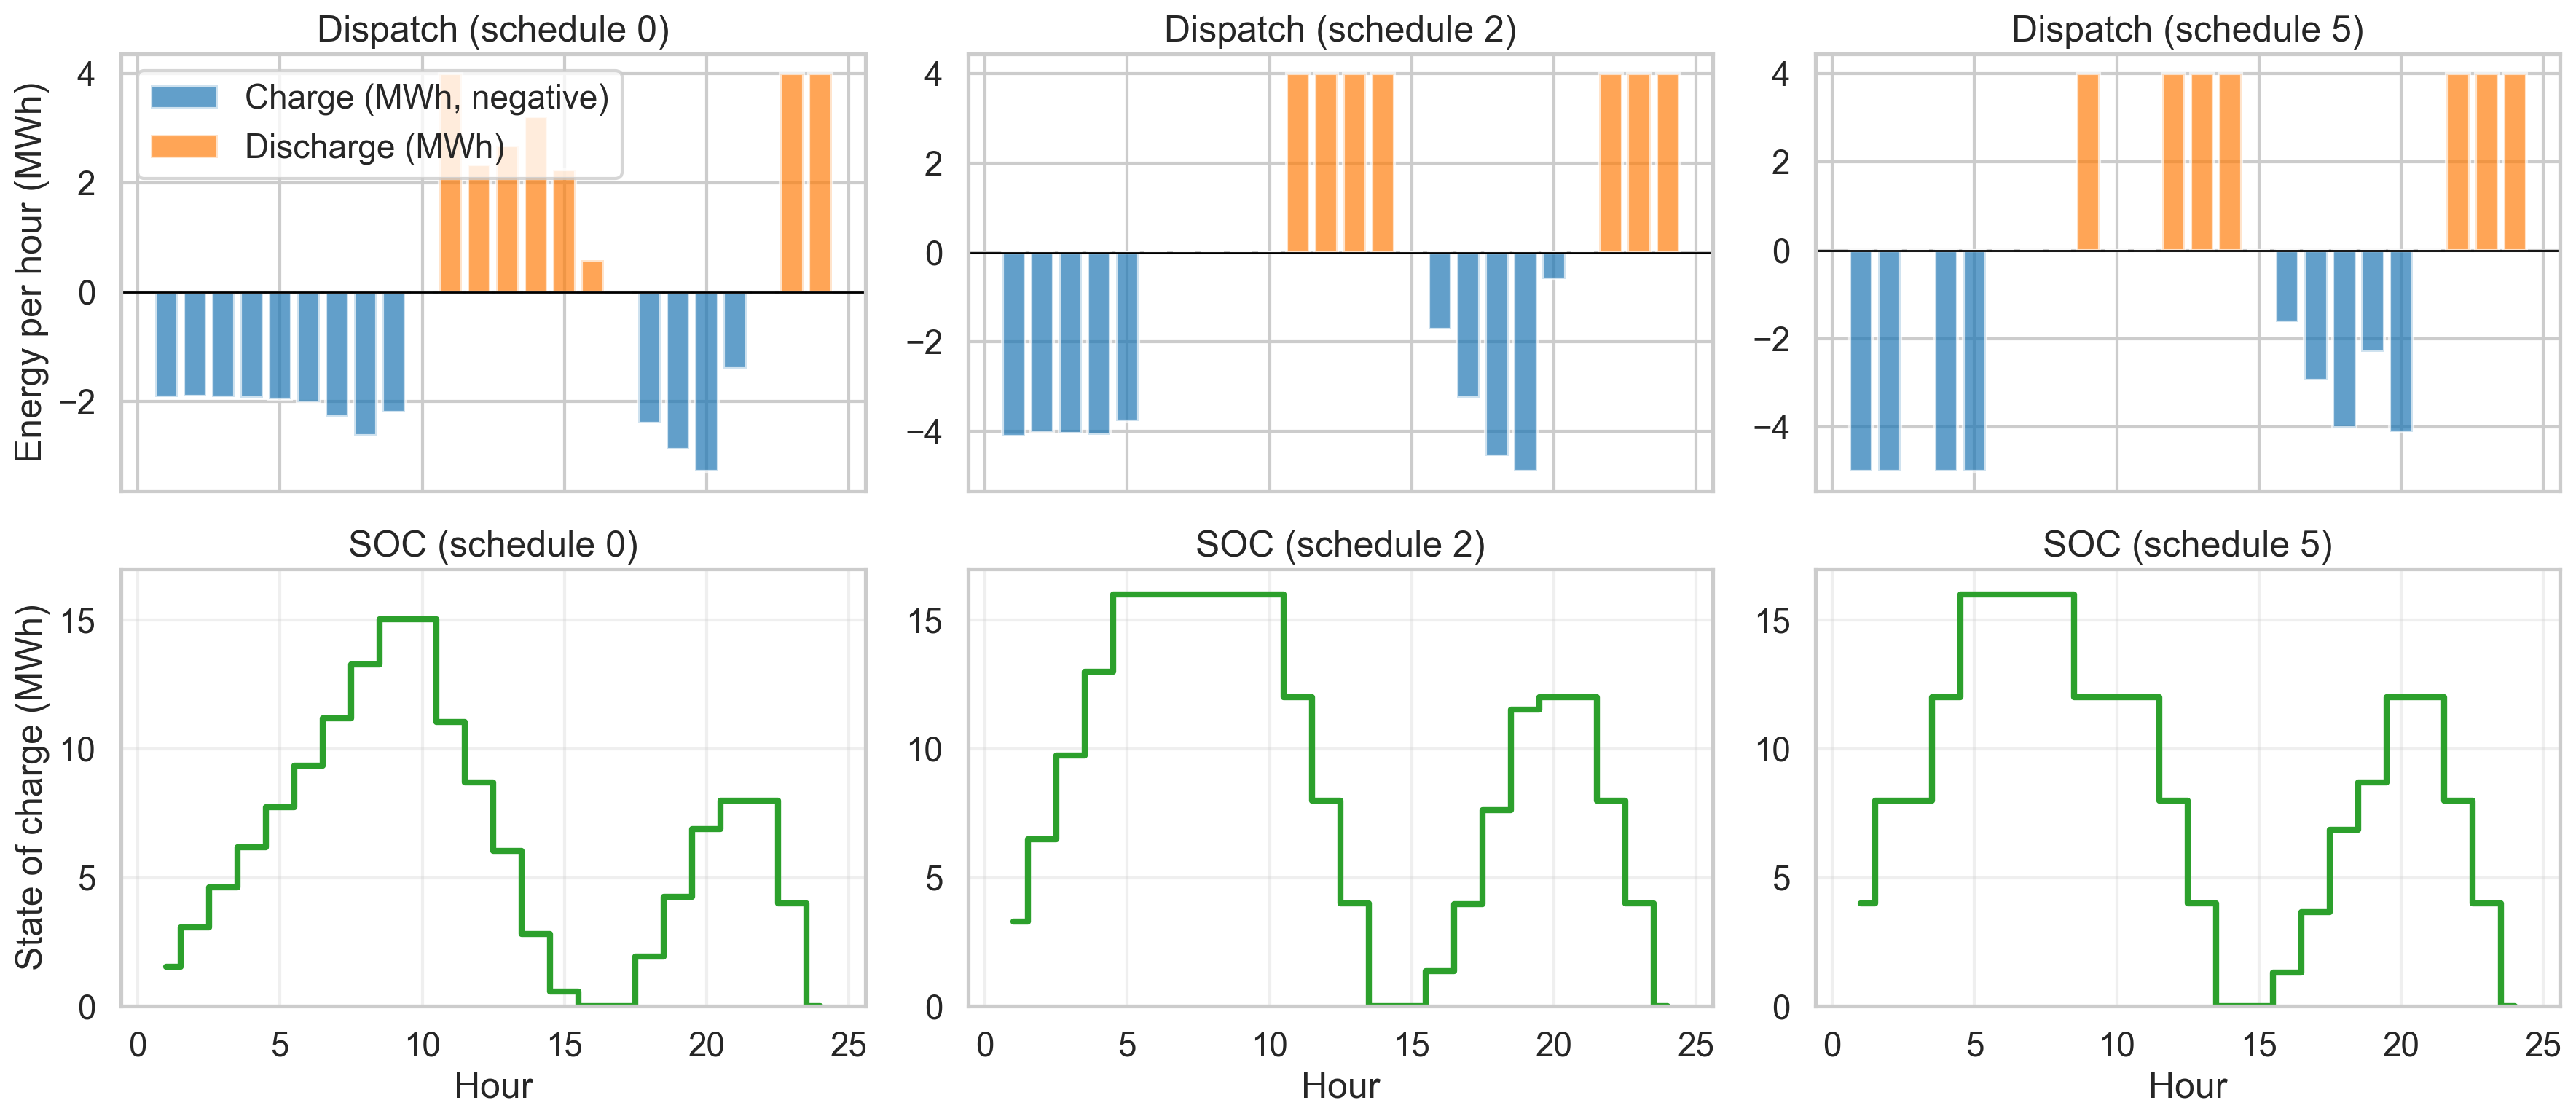

In [30]:
# Compare three solutions (indices 0, 6, 12) in a 2x3 grid: dispatch (top) + SOC (bottom)
indices = [0, 2, 5]
fig, axes = plt.subplots(2, 3, figsize=(18, 8), sharex=True)

charge_color = "#1f77b4"
discharge_color = "#ff7f0e"
soc_color = "#2ca02c"

for col, idx in enumerate(indices):
    sched = schedules[idx]
    hours = sched["hour"]

    # Dispatch bars
    ax_top = axes[0, col]
    ax_top.bar(hours, -sched["charge_MWh"], width=0.8, color=charge_color, alpha=0.7, label="Charge (MWh, negative)")
    ax_top.bar(hours, sched["discharge_MWh"], width=0.8, color=discharge_color, alpha=0.7, label="Discharge (MWh)")
    ax_top.axhline(0, color="black", linewidth=1)
    ax_top.set_title(f"Dispatch (schedule {idx})")
    if col == 0:
        ax_top.set_ylabel("Energy per hour (MWh)")

    # SOC trajectory
    ax_bot = axes[1, col]
    ax_bot.step(hours, sched["soc_MWh"], where="mid", linewidth=3, color=soc_color)
    ax_bot.set_ylim(0, Emax + 1)
    ax_bot.grid(True, alpha=0.3)
    ax_bot.set_title(f"SOC (schedule {idx})")
    ax_bot.set_xlabel("Hour")
    if col == 0:
        ax_bot.set_ylabel("State of charge (MWh)")

# Single legend for dispatch bars
handles, labels = axes[0, 0].get_legend_handles_labels()
axes[0, 0].legend(handles, labels, loc="upper left")

plt.tight_layout()
plt.show()


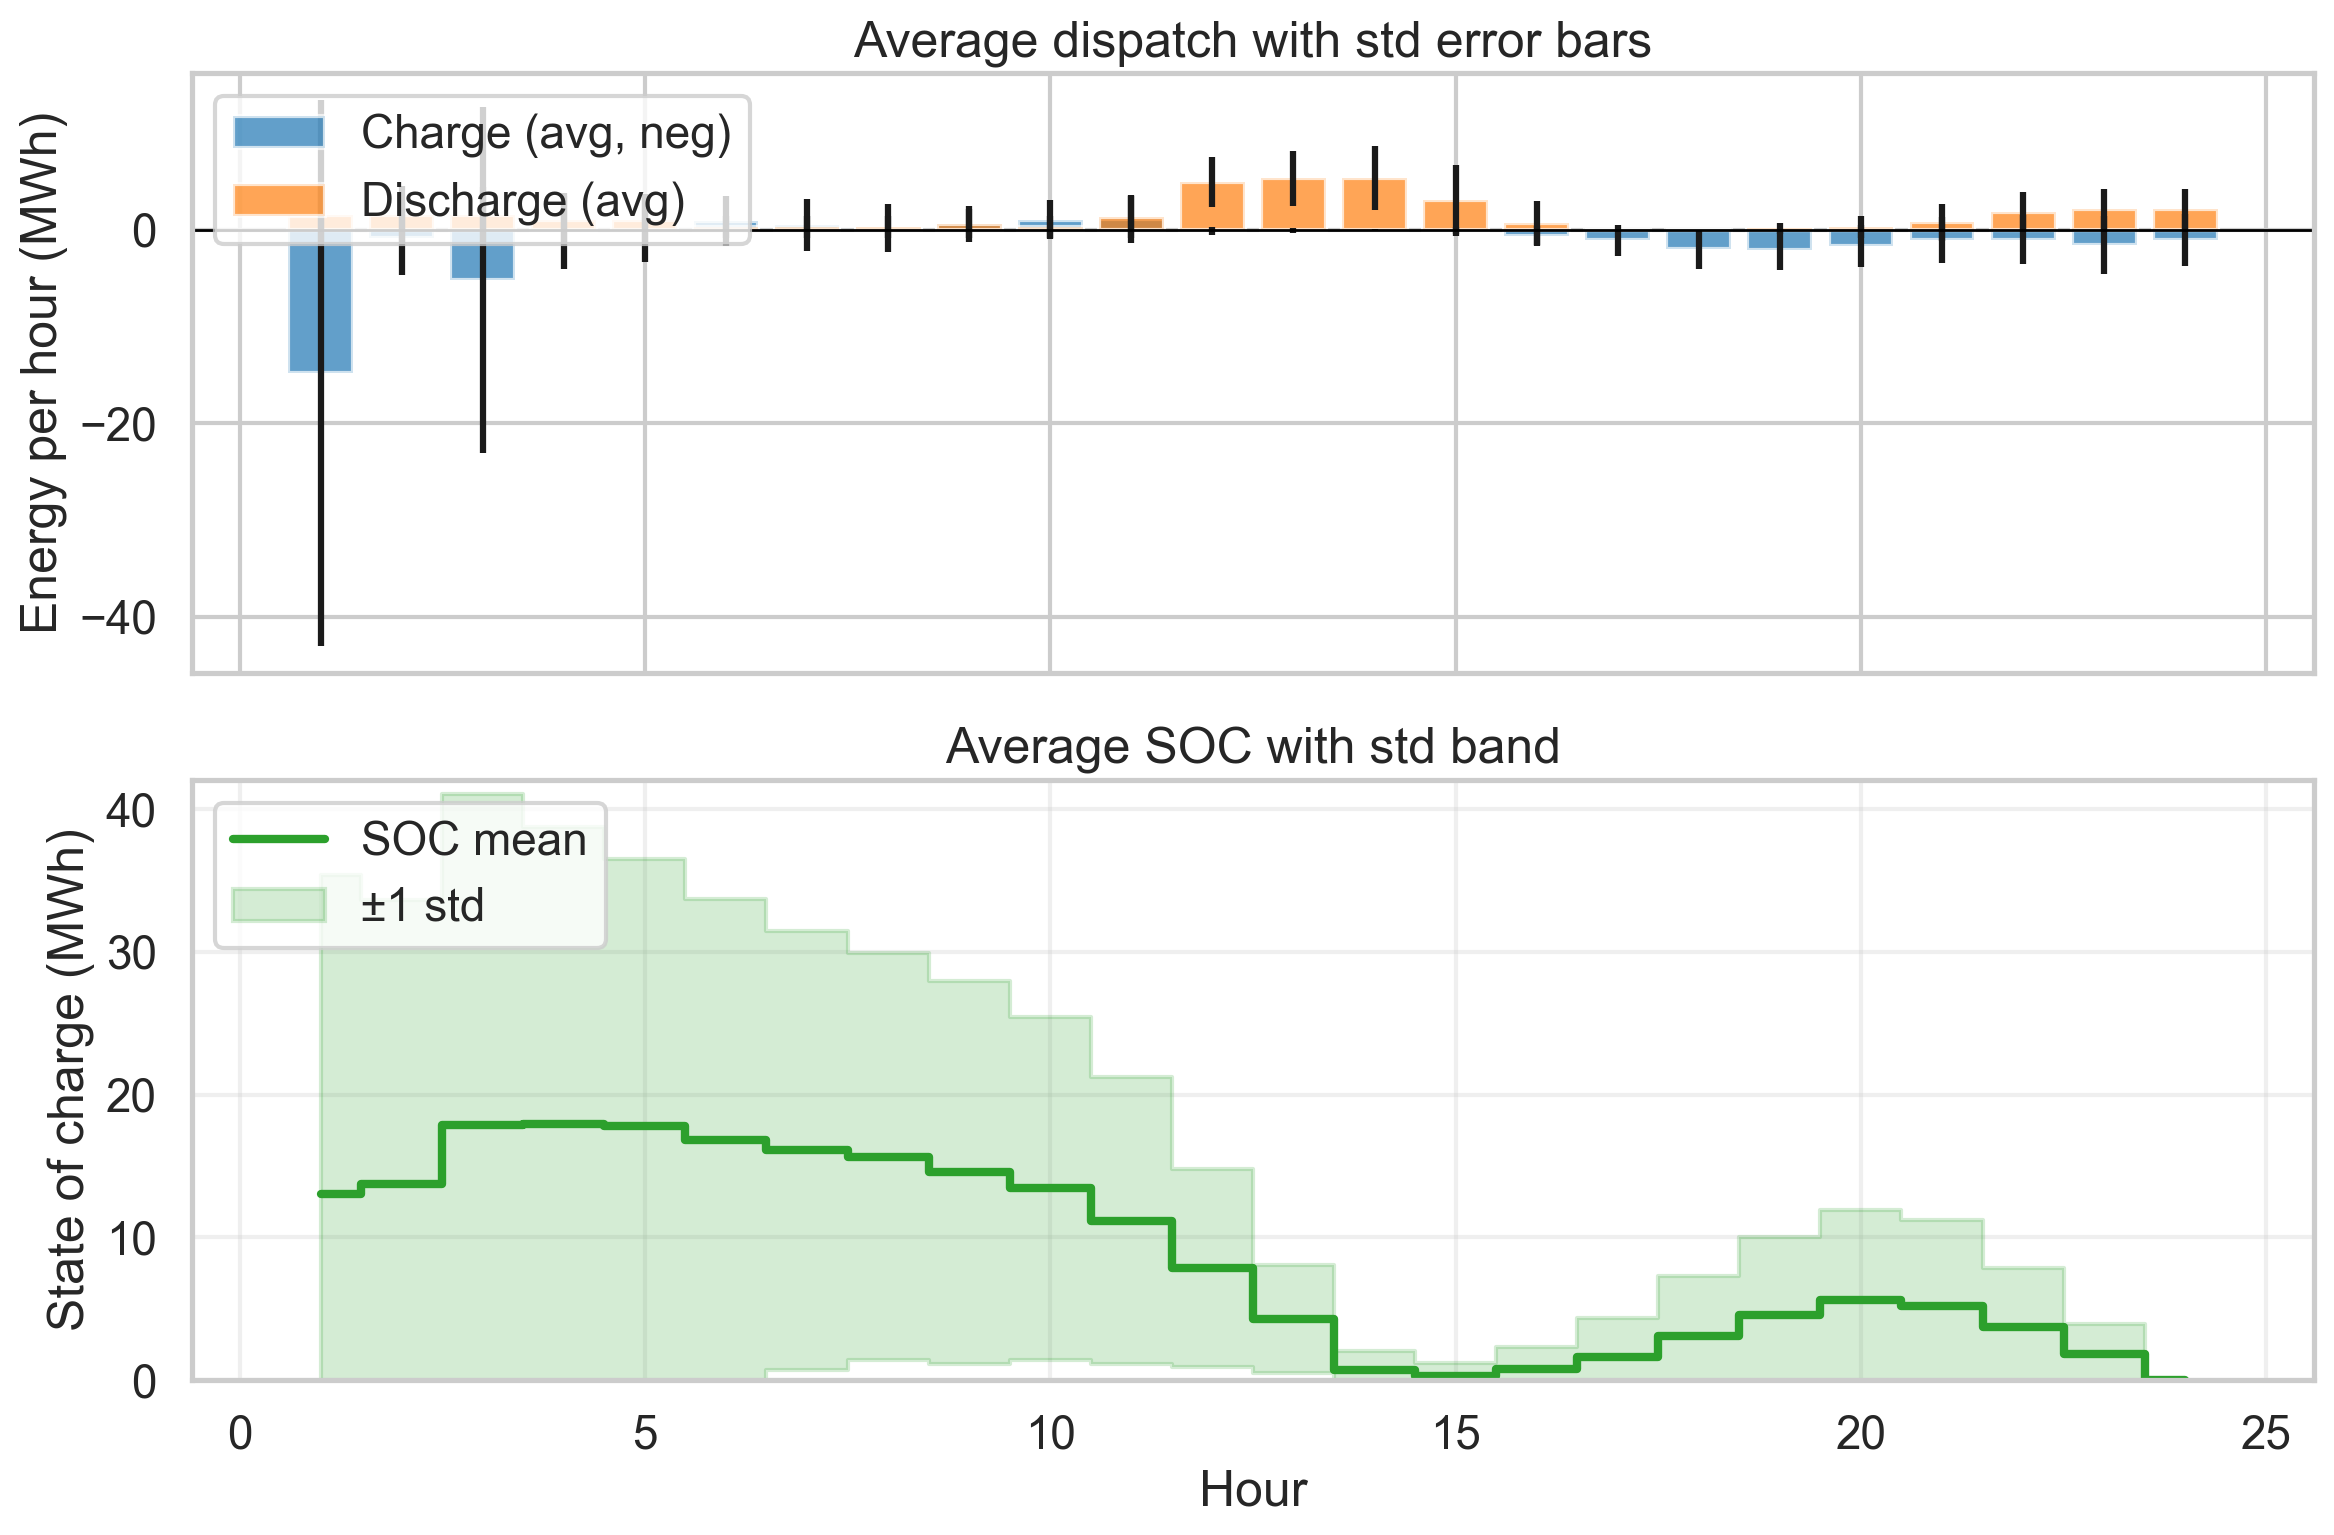

In [31]:
# Aggregate dispatch and SOC across all schedules (averages + std)
all_sched = pd.concat(schedules, keys=range(len(schedules)), names=["scenario", "row"])
agg = (
    all_sched
    .groupby("hour")[["charge_MWh", "discharge_MWh", "soc_MWh"]]
    .agg(["mean", "std"])
)

hours = agg.index

# Dispatch histogram with error bars (std)
fig, (ax_disp, ax_soc) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

charge_mean = -agg[("charge_MWh", "mean")]          # negative for charge
charge_std = agg[("charge_MWh", "std")]
discharge_mean = agg[("discharge_MWh", "mean")]
discharge_std = agg[("discharge_MWh", "std")]

ax_disp.bar(hours, charge_mean, yerr=charge_std, width=0.8, color="#1f77b4", alpha=0.7, label="Charge (avg, neg)")
ax_disp.bar(hours, discharge_mean, yerr=discharge_std, width=0.8, color="#ff7f0e", alpha=0.7, label="Discharge (avg)")
ax_disp.axhline(0, color="black", linewidth=1)
ax_disp.set_ylabel("Energy per hour (MWh)")
ax_disp.set_title("Average dispatch with std error bars")
ax_disp.legend(loc="upper left")

# SOC with mean + std band
soc_mean = agg[("soc_MWh", "mean")]
soc_std = agg[("soc_MWh", "std")]

ax_soc.step(hours, soc_mean, where="mid", linewidth=3, color="#2ca02c", label="SOC mean")
ax_soc.fill_between(hours, soc_mean - soc_std, soc_mean + soc_std, color="#2ca02c", alpha=0.2, step="mid", label="±1 std")
ax_soc.set_ylabel("State of charge (MWh)")
ax_soc.set_xlabel("Hour")
ax_soc.set_ylim(0, max(Emax, (soc_mean + soc_std).max()) + 1)
ax_soc.grid(True, alpha=0.3)
ax_soc.set_title("Average SOC with std band")
ax_soc.legend(loc="upper left")

plt.tight_layout()
plt.show()


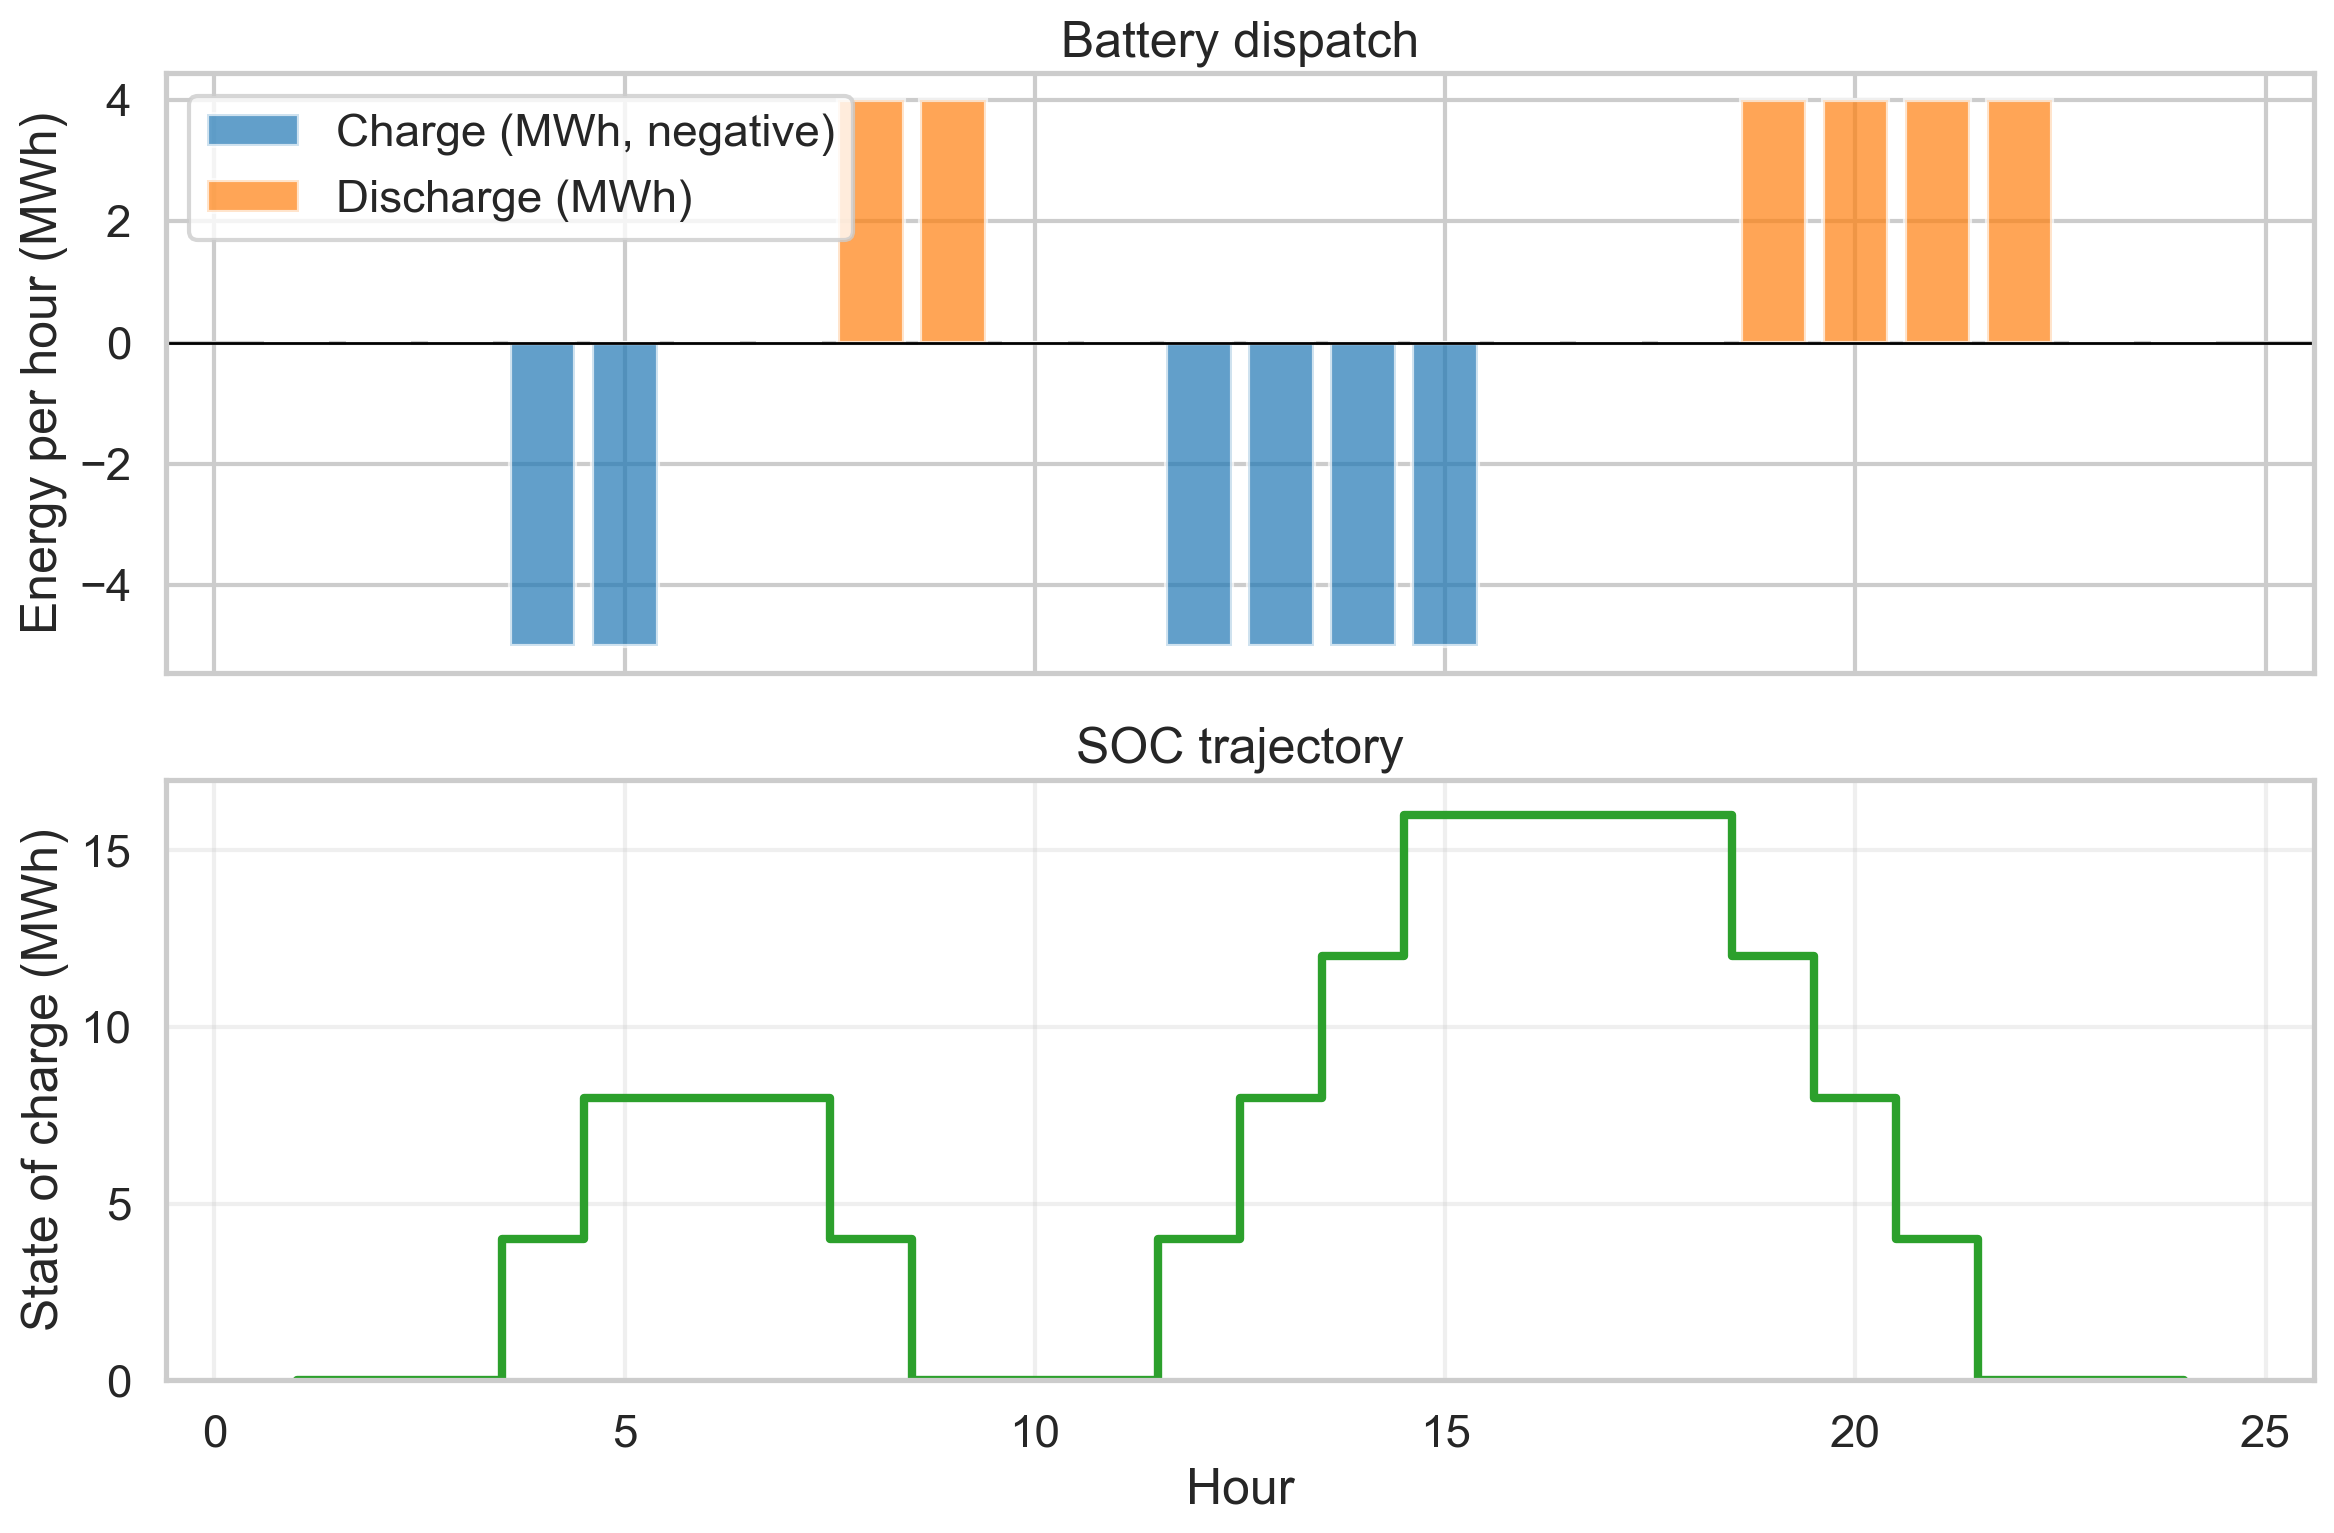

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# assumes you already solved the MILP and have:
# - schedule: DataFrame with columns ['hour','charge_MWh','discharge_MWh','soc_MWh', ...]
# - Emax: battery capacity (16.0)

# Dispatch visualization (same style as your snippet)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

ax1.bar(
    schedule["hour"],
    -schedule["charge_MWh"],
    width=0.8,
    color="#1f77b4",
    alpha=0.7,
    label="Charge (MWh, negative)",
)
ax1.bar(
    schedule["hour"],
    schedule["discharge_MWh"],
    width=0.8,
    color="#ff7f0e",
    alpha=0.7,
    label="Discharge (MWh)",
)
ax1.axhline(0, color="black", linewidth=1)
ax1.set_ylabel("Energy per hour (MWh)")
ax1.legend(loc="upper left")
ax1.set_title("Battery dispatch")

ax2.step(schedule["hour"], schedule["soc_MWh"], where="mid", linewidth=3, color="#2ca02c")
ax2.set_ylabel("State of charge (MWh)")
ax2.set_xlabel("Hour")
ax2.set_ylim(0, Emax + 1)
ax2.grid(True, alpha=0.3)
ax2.set_title("SOC trajectory")

plt.tight_layout()
plt.show()


In [17]:
# Count charge/discharge blocks from mode changes (no need for start variables)
mc = schedule["mode_charge"].to_numpy()
md = schedule["mode_discharge"].to_numpy()

charge_blocks = int((mc[0] == 1) + np.sum((mc[1:] == 1) & (mc[:-1] == 0)))
dis_blocks    = int((md[0] == 1) + np.sum((md[1:] == 1) & (md[:-1] == 0)))

print("Charge blocks:", charge_blocks, "| Discharge blocks:", dis_blocks)


Charge blocks: 2 | Discharge blocks: 2


## Results recap
- Classical arbitrage (with EFC <=2 and charge/discharge exclusivity) yields battery profit ~ EUR 2,034.54; wind expected revenue ~ EUR 17,645.48; total ~ EUR 19,680.02.
- The optimal schedule charges hours 4-5 and 12-15 (5 MWh each hour) and discharges hours 8-9 and 19-22 (4 MWh each hour), finishing empty.
- Full-cycle-only enforcement (two 0->16->0 blocks) gives battery profit ~ EUR 1,957.32; total ~ EUR 19,602.80.
- Wind scenarios remain independent of the battery because there is no netting; to couple them, add shared export/import limits or imbalance/curtailment terms.


## Quantum part

In [39]:
import numpy as np
from scipy.optimize import minimize
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import DiagonalGate


def profit_block(prices_arr, charge_start, discharge_start):
    # fixed 4h blocks, 1-indexed
    ch = np.arange(charge_start, charge_start + 4)
    dis = np.arange(discharge_start, discharge_start + 4)
    return -5.0 * prices_arr[ch - 1].sum() + 4.0 * prices_arr[dis - 1].sum()


def window_sums(prices_arr, L=4):
    # returns list [(sum, start)] for start=1..(24-L+1)=21
    return [(prices_arr[i-1:i-1+L].sum(), i) for i in range(1, 25 - L + 1)]


def top_k_starts(prices_arr, L=4, k=8, start_min=1, start_max=21, smallest=True):
    vals = [(s, i) for (s, i) in window_sums(prices_arr, L) if start_min <= i <= start_max]
    vals.sort(key=lambda x: x[0], reverse=not smallest)
    return [i for _, i in vals[:k]]


def feasible_pairs_single_cycle(
    prices_arr,
    i_min=1,
    require_idle_gap=True,
    prefilter=True,
    k=8
):
    """
    One cycle: CH i..i+3, DIS j..j+3.
    If require_idle_gap=True, enforce your MILP no-reversal rule => j >= i+5.
    Also enforce i<=21, j<=21 (blocks fit in 24h).
    If prefilter=True, restrict i to k cheapest 4h windows (>=i_min) and
    j to k priciest 4h windows (>=i_min+gap), to reduce qubits.
    """
    gap = 5 if require_idle_gap else 4
    i_min = int(i_min)

    if i_min > 21:
        return []

    if prefilter:
        cand_i = top_k_starts(prices_arr, L=4, k=k, start_min=i_min, start_max=21, smallest=True)
        # priciest discharge windows: sort descending by sum
        cand_j = top_k_starts(prices_arr, L=4, k=k, start_min=i_min + gap, start_max=21, smallest=False)
    else:
        cand_i = list(range(i_min, 22))
        cand_j = list(range(1, 22))

    pairs = []
    for i in cand_i:
        min_j = max(i + gap, i_min + gap)
        for j in cand_j:
            if 1 <= i <= 21 and 1 <= j <= 21 and j >= min_j:
                pairs.append((i, j))

    return sorted(set(pairs))


def build_cost_table_indexed(prices_arr, pairs, invalid_penalty=None):
    """
    Index feasible pairs by k=0..M-1, embed into 2^n basis states.
    cost(k) = -profit(pairs[k]) for k<M; else invalid_penalty.
    """
    M = len(pairs)
    if M == 0:
        return None, None, None

    n = int(np.ceil(np.log2(max(M, 2))))
    N = 2**n

    profits = np.array([profit_block(prices_arr, i, j) for (i, j) in pairs], dtype=float)
    max_abs = float(np.max(np.abs(profits))) if M else 1.0
    if invalid_penalty is None:
        invalid_penalty = 50.0 * max_abs

    cost_raw = np.full(N, invalid_penalty, dtype=float)
    for k, (i, j) in enumerate(pairs):
        cost_raw[k] = -profit_block(prices_arr, i, j)

    cmin, cmax = float(cost_raw.min()), float(cost_raw.max())
    cost_scaled = (cost_raw - cmin) / (cmax - cmin + 1e-12)
    return cost_raw, cost_scaled, n


def qaoa_indexed(prices_arr, pairs, p_layers=1, restarts=12, maxiter=80, seed=0):
    """
    Returns: (i_star, j_star, best_cost_raw, best_params, probs, n_qubits)
    """
    cost_raw, cost_scaled, n = build_cost_table_indexed(prices_arr, pairs)
    if cost_raw is None:
        return None, None, None, None, None, None

    rng = np.random.default_rng(seed)

    def make_circuit(gammas, betas):
        qc = QuantumCircuit(n)
        qc.h(range(n))
        for l in range(p_layers):
            gamma = float(gammas[l]) % (2*np.pi)
            beta  = float(betas[l])  % (np.pi)

            diag = np.exp(-1j * gamma * cost_scaled)  # length 2^n
            qc.append(DiagonalGate(diag), range(n))

            for q in range(n):
                qc.rx(2.0 * beta, q)
        return qc

    def expected_cost(params):
        gammas = params[:p_layers]
        betas  = params[p_layers:]
        qc = make_circuit(gammas, betas)
        sv = Statevector.from_instruction(qc)
        probs = sv.probabilities()
        return float(np.dot(probs, cost_scaled))

    # restarts
    starts = [np.concatenate([np.full(p_layers, np.pi), np.full(p_layers, np.pi/4)])]
    for _ in range(restarts):
        starts.append(np.concatenate([
            rng.uniform(0, 2*np.pi, size=p_layers),
            rng.uniform(0, np.pi,   size=p_layers),
        ]))

    best_fun, best_params = None, None
    for x0 in starts:
        res = minimize(expected_cost, x0, method="COBYLA", options={"maxiter": maxiter})
        if best_fun is None or res.fun < best_fun:
            best_fun, best_params = float(res.fun), res.x

    qc = make_circuit(best_params[:p_layers], best_params[p_layers:])
    sv = Statevector.from_instruction(qc)
    probs = sv.probabilities()

    M = len(pairs)
    k_star = int(np.argmax(probs[:M]))
    i_star, j_star = pairs[k_star]
    best_cost_raw = float(cost_raw[k_star])
    return i_star, j_star, best_cost_raw, best_params, probs, n


def sequential_two_cycle_qaoa(
    prices_arr,
    lambda_switch,
    require_idle_gap=True,
    prefilter=True,
    k=8,
    p_layers=1,
    restarts=12,
    maxiter=80,
    seed=1
):
    """
    Run QAOA twice:
      cycle1: choose (i1,j1)
      cycle2: choose (i2,j2) with i2 >= j1+5 (if require_idle_gap) so DIS->CH has an idle hour.
    Returns: list of blocks [("charge",a,b),("discharge",c,d), ...] and a diagnostic dict.
    """
    gap = 5 if require_idle_gap else 4

    # --- cycle 1
    pairs1 = feasible_pairs_single_cycle(prices_arr, i_min=1, require_idle_gap=require_idle_gap,
                                         prefilter=prefilter, k=k)
    i1, j1, cost1, params1, probs1, nq1 = qaoa_indexed(
        prices_arr, pairs1, p_layers=p_layers, restarts=restarts, maxiter=maxiter, seed=seed
    )
    if i1 is None:
        return [], {"reason": "no_feasible_pairs_cycle1"}

    prof1 = -cost1
    net1 = prof1 - 2.0 * lambda_switch  # one CH start + one DIS start
    if net1 <= 0:
        return [], {"reason": "cycle1_not_worth_start_penalty", "profit1": prof1, "net1": net1, "nq1": nq1}

    # earliest possible second charge start after first discharge block + mandatory idle hour
    # discharge occupies j1..j1+3, need idle at j1+4, so i2 >= j1+5
    i2_min = j1 + gap

    # --- cycle 2
    pairs2 = feasible_pairs_single_cycle(prices_arr, i_min=i2_min, require_idle_gap=require_idle_gap,
                                         prefilter=prefilter, k=k)
    i2 = j2 = None
    prof2 = net2 = 0.0
    nq2 = None

    if len(pairs2) > 0:
        i2, j2, cost2, params2, probs2, nq2 = qaoa_indexed(
            prices_arr, pairs2, p_layers=p_layers, restarts=restarts, maxiter=maxiter, seed=seed + 17
        )
        prof2 = -cost2
        net2 = prof2 - 2.0 * lambda_switch
        if net2 <= 0:
            i2 = j2 = None  # skip second cycle if not worth the start penalty

    blocks = [("charge", i1, i1 + 3), ("discharge", j1, j1 + 3)]
    if i2 is not None:
        blocks += [("charge", i2, i2 + 3), ("discharge", j2, j2 + 3)]

    diag = {
        "cycle1": {"i": i1, "j": j1, "profit": prof1, "net": net1, "n_qubits": nq1, "pairs": len(pairs1)},
        "cycle2": {"i": i2, "j": j2, "profit": prof2, "net": net2, "n_qubits": nq2, "pairs": len(pairs2),
                   "i_min": i2_min},
        "require_idle_gap": require_idle_gap,
        "prefilter": prefilter,
        "k": k
    }
    return blocks, diag


In [40]:
# -----------------------
# Sequential QAOA warm start (two cycles max)
# -----------------------
prices_arr = df["price"].to_numpy()

blocks, diag = sequential_two_cycle_qaoa(
    prices_arr=prices_arr,
    lambda_switch=lambda_switch,
    require_idle_gap=True,     # must match your MILP "no immediate reversal" constraints
    prefilter=True,            # reduces qubits; relies more on classical pruning
    k=8,                       # tune: smaller => fewer qubits but less search
    p_layers=1,
    restarts=12,
    maxiter=80,
    seed=1
)

print("QAOA blocks:", blocks)
print("Diagnostics:", diag)

# Helper
def in_any_block(t, blocks, kind, L=4):
    for k, a, b in blocks:
        if k == kind and a <= t <= b:
            return True
    return False

# -----------------------
# Apply MIPStart values consistent with YOUR formulation
# -----------------------
soc_val = {0: 0.0}
soc[0].setInitialValue(0.0)

prev_uch, prev_udis = 0, 0

for t in hours:
    if in_any_block(t, blocks, "charge"):
        uch0, udis0, uid0 = 1, 0, 0
        ch0, dis0 = Pch, 0.0
    elif in_any_block(t, blocks, "discharge"):
        uch0, udis0, uid0 = 0, 1, 0
        ch0, dis0 = 0.0, Pdis
    else:
        uch0, udis0, uid0 = 0, 0, 1
        ch0, dis0 = 0.0, 0.0

    u_ch[t].setInitialValue(uch0)
    u_dis[t].setInitialValue(udis0)
    u_id[t].setInitialValue(uid0)

    charge[t].setInitialValue(ch0)
    discharge[t].setInitialValue(dis0)

    # starts implied by mode change
    start_ch0  = 1 if (uch0 == 1 and prev_uch == 0) else 0
    start_dis0 = 1 if (udis0 == 1 and prev_udis == 0) else 0
    start_ch[t].setInitialValue(start_ch0)
    start_dis[t].setInitialValue(start_dis0)

    # SOC forward compute
    soc_val[t] = soc_val[t-1] + eta_ch * ch0 - (1.0/eta_dis) * dis0
    soc_val[t] = max(0.0, min(Emax, soc_val[t]))
    soc[t].setInitialValue(soc_val[t])

    prev_uch, prev_udis = uch0, udis0

print("Warm-start end SOC:", soc_val[hours[-1]])

# -----------------------
# Solve with warm start (CBC)
# -----------------------
solver = pulp.PULP_CBC_CMD(msg=1, warmStart=True, keepFiles=True)
model.solve(solver)


QAOA blocks: [('charge', 11, 14), ('discharge', 19, 22)]
Diagnostics: {'cycle1': {'i': 11, 'j': 19, 'profit': 1796.56, 'net': 1776.56, 'n_qubits': 5, 'pairs': 30}, 'cycle2': {'i': None, 'j': None, 'profit': 0.0, 'net': 0.0, 'n_qubits': None, 'pairs': 0, 'i_min': 24}, 'require_idle_gap': True, 'prefilter': True, 'k': 8}
Warm-start end SOC: 0.0


1

In [41]:
status = pulp.LpStatus[model.status]
battery_profit = pulp.value(battery_revenue)
total_revenue = pulp.value(model.objective)

print('Solver status:', status)
print(f"Expected wind revenue: EUR {wind_rev_exp:,.2f}")
print(f"Scenario range: EUR {wind_rev_min:,.2f} .. EUR {wind_rev_max:,.2f}")
print(f"Battery profit: EUR {battery_profit:,.2f}")
print(f"Total expected revenue (wind + battery): EUR {total_revenue:,.2f}")

schedule = pd.DataFrame({
    'hour': hours,
    'charge_MWh': [charge[t].value() for t in hours],
    'discharge_MWh': [discharge[t].value() for t in hours],
    'soc_MWh': [soc[t].value() for t in hours],
    'mode_charge': [u_ch[t].value() for t in hours],
    'mode_discharge': [u_dis[t].value() for t in hours],
    'price': [prices[t] for t in hours],
})

# Clean “mode” based on actual actions (recommended)
eps = 1e-6
schedule["mode_clean"] = np.where(
    schedule["charge_MWh"] > eps, "CH",
    np.where(schedule["discharge_MWh"] > eps, "DIS", "IDLE")
)

# Show only active hours
active = schedule[(schedule["charge_MWh"] > eps) | (schedule["discharge_MWh"] > eps)]
print("\nActive hours:")
print(active[["hour","price","mode_clean","charge_MWh","discharge_MWh","soc_MWh"]].to_string(index=False))

# If you want the full 24h table:
print(schedule[["hour","price","mode_clean","charge_MWh","discharge_MWh","soc_MWh"]].to_string(index=False))


Solver status: Optimal
Expected wind revenue: EUR 17,645.48
Scenario range: EUR 5,515.79 .. EUR 27,116.03
Battery profit: EUR 2,034.54
Total expected revenue (wind + battery): EUR 19,640.02

Active hours:
 hour  price mode_clean  charge_MWh  discharge_MWh  soc_MWh
    4  82.56         CH         5.0            0.0      4.0
    5  82.82         CH         5.0            0.0      8.0
    8 133.09        DIS         0.0            4.0      4.0
    9 113.73        DIS         0.0            4.0      0.0
   12  19.97         CH         5.0            0.0      4.0
   13  16.49         CH         5.0            0.0      8.0
   14  13.72         CH         5.0            0.0     12.0
   15  18.62         CH         5.0            0.0     16.0
   19 125.03        DIS         0.0            4.0     12.0
   20 147.60        DIS         0.0            4.0      8.0
   21 151.42        DIS         0.0            4.0      4.0
   22 130.49        DIS         0.0            4.0      0.0
 hour  price mo